# Импорт библиотек

In [1]:
import shap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

### Функция для обучения базовой модели

In [2]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=500,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostRegressor(
        iterations= n_iter,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=True
    )

    return model

# Чтение данных

In [3]:
train_df = pd.read_csv('data/train.csv', sep=";", decimal=",", encoding="windows-1251")
test_df = pd.read_csv('data/test.csv', sep=";", decimal=",", encoding="windows-1251")

features_description = (
    pd.read_excel('data/description.xlsx', index_col='field')
    .to_dict()['description']
)

train_df.shape, test_df.shape

((205962, 235), (37183, 233))

# Предварительный анализ EDA

In [4]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

### Поправляем типы данных для фичей

In [5]:
print('Количество униклаьных значений по фиче:')
for f in train_df[features].select_dtypes('object').columns:
    print(f"{f}: {train_df[f].value_counts().count()}")

Количество униклаьных значений по фиче:
addrref: 59
bki_total_ip_max_limit: 2763
hdb_bki_active_cc_cnt: 60
hdb_bki_active_ip_max_outstand: 43267
hdb_bki_active_micro_max_outstand: 5458
hdb_bki_active_pil_max_overdue: 24365
hdb_bki_other_active_auto_month_payments_sum: 3533
hdb_bki_total_cc_max_limit: 9991
hdb_bki_total_ip_cnt: 15
hdb_bki_total_max_limit: 52263
hdb_bki_total_max_overdue_sum: 56162
hdb_bki_total_pil_max_limit: 54202
main_last_position_ccode: 9207
main_pre_last_position_ccode: 5192
oldest_campaignsegment_ccode_for_nss: 56
oldest_campaignsegment_ccode_for_pil: 13
part_last_position_ccode: 1236
part_pre_last_position_ccode: 1325
segment: 3
brand: 422
model: 2397


В соответствии с описанием фичей было выяснено, что для всех фичей, которые начинаются с 'hdb_bki' требуется выставить тип данных float

In [6]:
newtype_feats = [
    'bki_total_ip_max_limit',
    'hdb_bki_active_cc_cnt',
    'hdb_bki_active_ip_max_outstand',
    'hdb_bki_active_micro_max_outstand',
    'hdb_bki_active_pil_max_overdue',
    'hdb_bki_other_active_auto_month_payments_sum',
    'hdb_bki_total_cc_max_limit',
    'hdb_bki_total_ip_cnt',
    'hdb_bki_total_max_limit',
    'hdb_bki_total_max_overdue_sum',
    'hdb_bki_total_pil_max_limit'
]

test_df[newtype_feats] = test_df[newtype_feats].astype('float64')
test_df['feature_date'] = test_df['feature_date'].astype('datetime64[ns]')

train_df[newtype_feats] = train_df[newtype_feats].astype('float64')
train_df['feature_date'] = train_df['feature_date'].astype('datetime64[ns]')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: datetime64[ns](1), float64(223), int64(1), object(10)
memory usage: 369.3+ MB


In [7]:
cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(231, 10, 221)

### Анализ категорильных фичей

In [8]:
# сколько всего записей, где известна должность, но не известна зп?
train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(4184, 235)

In [9]:
# df, содержащий медианные зарплаты для должностей по всем данным
median_worksalary = (
    pd.concat([train_df[features], test_df[features]], axis=0)
    .dropna(subset = 'worksalary_rur_amt')
    .groupby('part_last_position_ccode', as_index=False)
    ['worksalary_rur_amt'].median()
    .rename(columns={'worksalary_rur_amt': 'median_worksalary_rur_amt'})
)
median_worksalary.head()

,part_last_position_ccode,median_worksalary_rur_amt
0,АВТОМЕХАНИК,158892.5
1,АДМИНИСТРАТОР,180000.0
2,АНАЛИТИК,100000.0
3,Администратор,60000.0
4,Администратор магазина,70000.0


In [10]:
test_df = test_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
test_df['worksalary_rur_amt'] = test_df['worksalary_rur_amt'].fillna(test_df['median_worksalary_rur_amt'])
test_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df = train_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
train_df['worksalary_rur_amt'] = train_df['worksalary_rur_amt'].fillna(train_df['median_worksalary_rur_amt'])
train_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(1029, 235)

In [11]:
# заполняем пропуски в категориальных
train_df[cat_features] = train_df[cat_features].fillna('miss_value')
test_df[cat_features] = test_df[cat_features].fillna('miss_value')

### Выводы
1. Много фичей с большой долей пропущенных значений
2. Клиентам с большим доходом присвоены высокие веса для метрики WMAE
3. Колонка segment не является сегментом доходности
4. На 31% таргет состоит из значений без дрообной части. Возможно округление предсказания модели даст эффект
5. Есть потенциально хорошие категориальные фичи (связанные с должностью и автомобилем), но они слабо заполнены

# Инженерия фич

In [12]:
train_df['feature_date_year'] = train_df['feature_date'].dt.year
train_df['feature_date_month'] = train_df['feature_date'].dt.month
train_df['feature_date_day'] = train_df['feature_date'].dt.day

test_df['feature_date_year'] = test_df['feature_date'].dt.year
test_df['feature_date_month'] = test_df['feature_date'].dt.month
test_df['feature_date_day'] = test_df['feature_date'].dt.day

In [13]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(234, 10, 224)

# Обучение модели

In [14]:
features_train, features_val, target_train, target_val, w_train, w_val = train_test_split(
    train_df[features],
    train_df['target'],
    train_df['w'],
    test_size=0.3,
    random_state=42
)

## Обучение модели на всех фичах

In [15]:
model = fit_catboost(features_train, features_val, w_train, w_val, cat_features, 500)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5067344	test: 0.5091759	best: 0.5091759 (0)	total: 250ms	remaining: 2m 4s
100:	learn: 0.3843214	test: 0.3893198	best: 0.3893198 (100)	total: 15s	remaining: 59.4s
200:	learn: 0.3726504	test: 0.3795572	best: 0.3795572 (200)	total: 29.4s	remaining: 43.7s
300:	learn: 0.3653868	test: 0.3743487	best: 0.3743487 (300)	total: 43.6s	remaining: 28.8s
400:	learn: 0.3600141	test: 0.3711791	best: 0.3711791 (400)	total: 58.2s	remaining: 14.4s
499:	learn: 0.3559297	test: 0.3692365	best: 0.3692365 (499)	total: 1m 12s	remaining: 0us

bestTest = 0.3692365079
bestIteration = 499



Text(0.5, 1.0, 'Residual Plot')

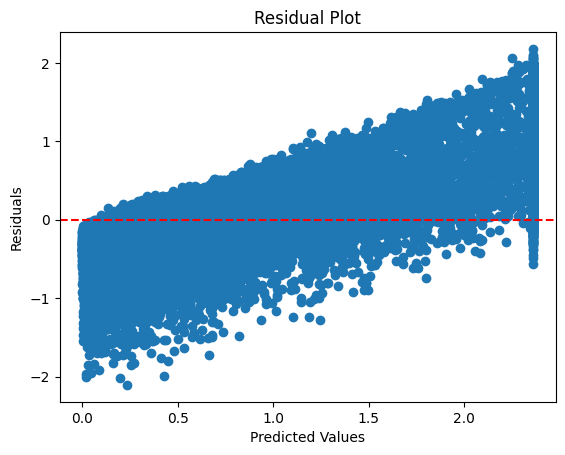

In [17]:
# Plot Residuals
residuals = w_val - model.predict(features_val)
plt.scatter(w_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

### Важность признаков

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



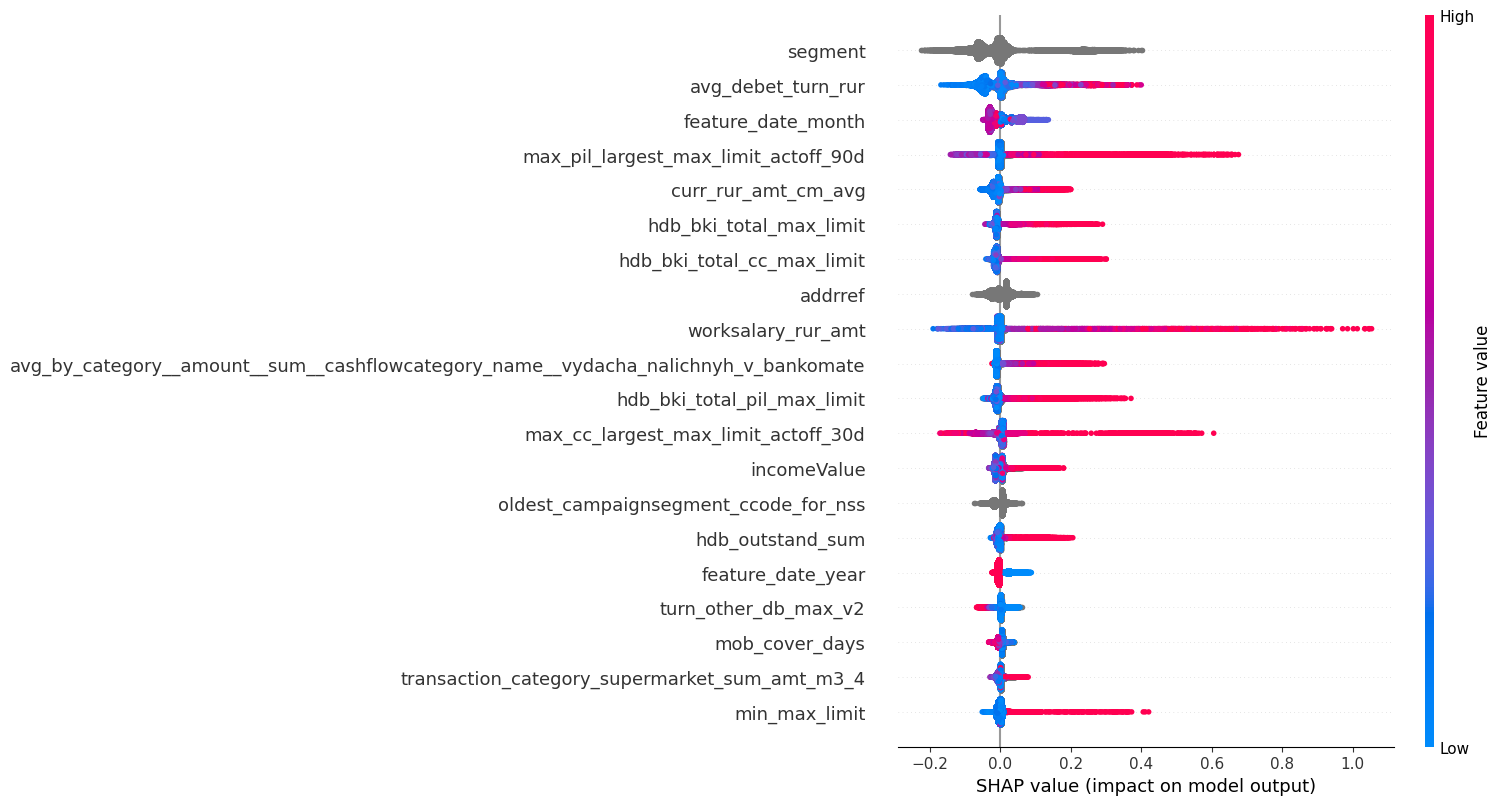

In [18]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

In [19]:
shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,segment,0.055683
1,avg_debet_turn_rur,0.053279
2,feature_date_month,0.025875
3,max_pil_largest_max_limit_actoff_90d,0.025661
4,curr_rur_amt_cm_avg,0.022735


## Отбор фич (факторный анализ)

In [20]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
27,first_salary_income,0.003632
52,hdb_bki_other_active_auto_month_payments_sum,0.001056
58,part_pre_last_position_ccode,0.000796
61,part_last_position_ccode,0.000698
67,model,0.000521
79,product_depozity_voc_features_full_voc_without...,0.000329
81,avg_by_category__amount__sum__cashflowcategory...,0.000286
90,unique_countries1,0.000144
96,brand,0.000104
103,min_cc_max_ul_actoff_180_30_inc,0.000085


146

Отброшены потенцильно хорошие фичи.
Вернем их в список фичей

In [30]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:9]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

155

In [31]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
27,first_salary_income,0.003632
52,hdb_bki_other_active_auto_month_payments_sum,0.001056
58,part_pre_last_position_ccode,0.000796
61,part_last_position_ccode,0.000698
67,model,0.000521
79,product_depozity_voc_features_full_voc_without...,0.000329
81,avg_by_category__amount__sum__cashflowcategory...,0.000286
90,unique_countries1,0.000144
96,brand,0.000104
172,channel_otdelenija_voc_features_full_voc_not_n...,0.000000


143

In [33]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:9]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

152

In [35]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])

    pool_train = Pool(
        df[features + ['random']],
        df['w'],
        cat_features = cat_features
    )

    simple_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 0.5073495	total: 199ms	remaining: 1m 39s
100:	learn: 0.3854729	total: 15.7s	remaining: 1m 2s
200:	learn: 0.3743192	total: 31.3s	remaining: 46.5s
300:	learn: 0.3674865	total: 47s	remaining: 31.1s
400:	learn: 0.3624632	total: 1m 2s	remaining: 15.5s
499:	learn: 0.3588512	total: 1m 18s	remaining: 0us


,feature,importance
72,channel_chat_s_operatorom_voc_features_full_vo...,0.000420
76,transaction_category_hotels_sum_amt_m2,0.000357
84,product_debetovye_karty_voc_features_full_voc_...,0.000220
87,product_debetovye_karty_voc_features_36m_mark_...,0.000183
88,transaction_category_house_repair_inc_cnt_2m,0.000182
90,unique_countries1,0.000144
91,channel_chatbot_voc_features_12m_mark_in_1_3_flag,0.000126
92,transaction_category_money_send_sum_cnt_m2,0.000125
93,product_kreditnye_karty_voc_features_3m_mark_e...,0.000123
95,channel_chat_s_operatorom_voc_features_12m_voc...,0.000108


96

## Обучение модели на фичах после факторного анализа

In [36]:
model = fit_catboost(
    features_train[selected_features], 
    features_val[selected_features], 
    w_train, 
    w_val, 
    cat_features, 
    500
)

print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5066674	test: 0.5090495	best: 0.5090495 (0)	total: 154ms	remaining: 1m 17s
100:	learn: 0.3844130	test: 0.3891443	best: 0.3891443 (100)	total: 13.3s	remaining: 52.5s
200:	learn: 0.3727115	test: 0.3793434	best: 0.3793434 (200)	total: 26.7s	remaining: 39.7s
300:	learn: 0.3653573	test: 0.3740342	best: 0.3740342 (300)	total: 40s	remaining: 26.4s
400:	learn: 0.3597927	test: 0.3708425	best: 0.3708425 (400)	total: 53.6s	remaining: 13.2s
499:	learn: 0.3554146	test: 0.3687361	best: 0.3687361 (499)	total: 1m 7s	remaining: 0us

bestTest = 0.3687360985
bestIteration = 499

Overfit: 0.013321511405661512


Text(0.5, 1.0, 'Residual Plot')

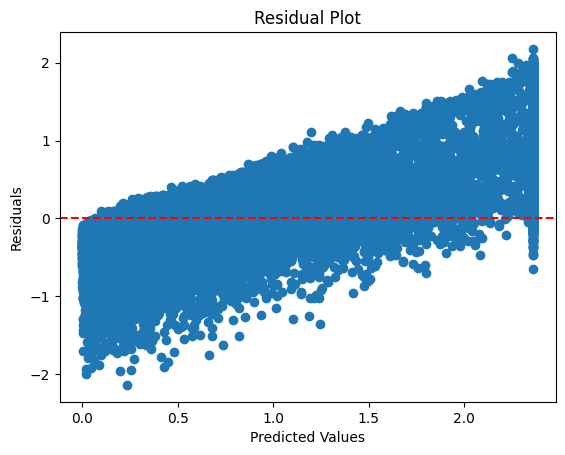

In [37]:
# Plot Residuals
residuals = w_val - model.predict(features_val[selected_features])
plt.scatter(w_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



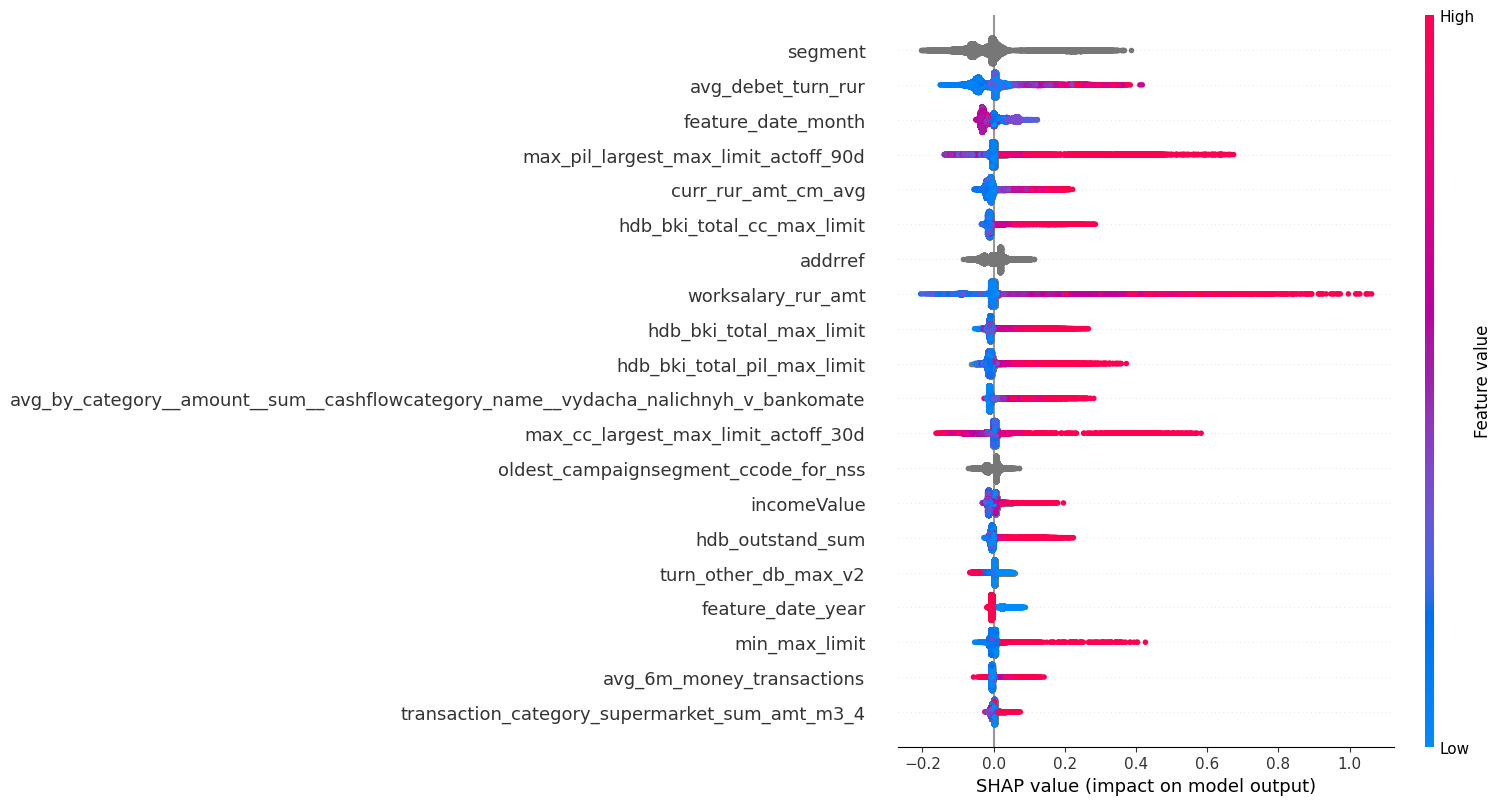

In [38]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val[selected_features])
)
shap.summary_plot(shap_values, features_val[selected_features])

# Инференс

In [39]:
pool_train = Pool(
    train_df[selected_features],
    train_df['w'],
    cat_features = selected_features_cat
)

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    loss_function='RMSE'
)

model.fit(
    pool_train,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5073279	total: 169ms	remaining: 1m 24s
100:	learn: 0.3854834	total: 16.2s	remaining: 1m 4s
200:	learn: 0.3736819	total: 32.1s	remaining: 47.8s
300:	learn: 0.3671502	total: 49.2s	remaining: 32.5s
400:	learn: 0.3622908	total: 1m 4s	remaining: 16s
499:	learn: 0.3587250	total: 1m 20s	remaining: 0us


# Сохранение модели

In [40]:
model.save_model('models/model_w')

# Гипотеза не подтвердилась  
На kaggle была получена метрика 35667 после добавления веса как фичи. Возможно models/model_w недостаточна точна. Принято решение отложить эту идею